# Functionality:

## Import Packages 

In [1]:
import os, sys
import numpy as np
import glob
import scipy.io as sio

from numpy.fft import fft, fftfreq

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# add path '../'
sys.path.append(os.path.abspath(os.path.join('..')))

# import animal_folder in ../util/folder_extract.pynb 
from util.folder_extract import animal_folder

importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Codes/FCAnalysis/util/folder_extract.ipynb


## Power Calculation

### power_return_1file()

In [2]:
def power_return_1file(filename, chns, freqs_all, tdur_min = 0.5, tdur_max = 0.75):
    """ 
    
        calculate the power of one file in return phase
        
        Args:
        
            filename: file name 
            
            chns: channel number, <class 'numpy.ndarray'>, shape = (nchns, )
            
            freqs_all: frequencies at which power will be calcualted, <class 'numpy.ndarray'>, shape = (nfreqs, )
            
            tdur_min, tdur_max: minimal and maximal duration for return phase
            
        Return:
            powers_freqs: calculated powers at freqs_all, shape = (nfreqs, )
            
    """
    
    ###  load data ###
    dat = sio.loadmat(filename, 
                  variable_names = ['idxevent', 'fs', 'lfptrial', 'idxevent_varNames'], 
                  squeeze_me = True,
                  mat_dtype = True)
    
    
    # extract idxevent: numpy.ndarray(shape = (ntrials, 5)), idxevent_varNames: numpy.ndarray(nshape = (5,))
    idxevent, idxevent_varNames = dat['idxevent'], dat['idxevent_varNames']

    # extract fs
    fs = dat['fs']

    # extract lfp trial: nchns * ntemporals * ntrials
    lfptrial = dat['lfptrial']

    # column index for event return
    coli_return = [i for i, s in enumerate(idxevent_varNames) if 'ReturnTimeix' in s]

    # column index for event Touch
    coli_mouth = [i for i, s in enumerate(idxevent_varNames) if 'MouthTimeix' in s]


    # column indices of return phase 
    cols_phasereturn = coli_return + coli_mouth

    cols = cols_phasereturn
    
    
    # minimal and maximal duration for return phase


    # idxdur_min, idxdur_max
    idxdur_min, idxdur_max = int(np.round(tdur_min * fs)), int(np.round(tdur_max * fs))

    
    ntrials, _= idxevent.shape

    # dictionary powers_dict for storing power of each frequency
    powers_dict = dict()

    ### calculate the power of each frequency in freqs_all from all the trials ###
    for triali in range(ntrials):

        ### data extraction part ###

        # start and end indices over time of specific phase for triali 
        idxtime_str, idxtime_end = int(idxevent[triali, cols[0]]), int(idxevent[triali, cols[1]])


        # remove trials of return phase longer than tdur_max and shorter than tdur_min
        if idxtime_end - idxtime_str < idxdur_min or idxtime_end - idxtime_str > idxdur_max:
            continue;


        # extract lfp data of chns in return phase for triali: shape = (nchns, ntemporals)
        lfp_return = lfptrial[chns, idxtime_str:idxtime_end, triali]

        # average across all the channels: shape = (ntemporals,)
        avglfp_return = np.mean(lfp_return, axis = 0)


        ### power calculation part ###

        # fft number
        nfft = len(avglfp_return)

        # Discrete Fourier Transform sample frequencies
        freqs = fftfreq(nfft, 1/fs)

        # ignore the negative frequencies
        idx_f = freqs >0
        freqs = freqs[idx_f]


        # compute the one-dimensional discrete Fourier transform
        fft_lfp = fft(avglfp_return)

        # power
        power_lfp = np.square(np.abs(fft_lfp))/nfft
        power_lfp = power_lfp[idx_f]


        ### round power to the nearest frequency in freqs_all ### 

        # index of the nearest frequency for all the frequency in freqs
        idx_round = [np.abs(freqs_all - freq).argmin() for freq in freqs if freq <= freqs_all[-1] + 0.5]

        # add power of each nearest frequency into dictionary powers_dict
        for i in idx_round:
            if i in powers_dict.keys():
                powers_dict[i] = powers_dict[i] + [power_lfp[i]]
            else:
                powers_dict[i] = [power_lfp[i]]

        ### delete temporal variables ###

        del idxtime_str, idxtime_end, lfp_return, avglfp_return
        del nfft, freqs, idx_f, fft_lfp, power_lfp
        del idx_round,i 


    # average across all trials
    powers_freqs = np.empty(shape=[0,])
    for freq in freqs_all:

        if freq in powers_dict.keys():

            # calculate the mean power
            power = np.mean(powers_dict[freq])
        
        else:
            # no power for freq
            power = -1

        # add to powers_freqs
        powers_freqs = np.append(powers_freqs, np.array([power]), axis = 0)

        del power
            

    powers_freqs = np.asarray(powers_freqs)
    
    return powers_freqs

### power_allfiles()

In [3]:
def power_allfiles(anidatfolder, condition, freqs_all, chns):
    
    """ 
    
        return the mean power of all file in one condition
        
        Args:
        
            anidatfolder: animal data folder
            
            condition: 'mild' or 'normal'
            
            freqs_all: frequencies at which power will be calcualted, <class 'numpy.ndarray'>, shape = (nfreqs, )
            
        Return:
            powers_freqs_allfiles: calculated powers at freqs_all 
            shape = (nfreqs, 2), first col: freq, second col: power
            
    
    
    """
    
    # epoch folder
    epochfolder = os.path.join(anidatfolder, 'epochs')

    # normal file pattern
    filepatt = os.path.join(epochfolder, "*" + condition + "*.mat") 

    # extract all .mat files in normal in epoch folder
    files = glob.glob(filepatt)
    
    nfreqs, nfiles = len(freqs_all), len(files)
    
    # powers_freqs_allfiles store the powers of all files, shape = (nfreqs, nfiles) 
    powers_freqs_allfiles = np.zeros((nfreqs, nfiles))
    
    # add power_freq of each file into powers_freqs_allfiles
    for filei, filename in enumerate(files):
        
        # the power of one file in return phase
        powers_freqs = power_return_1file(filename, chns, freqs_all, tdur_min = 0.5, tdur_max = 0.75)  
        
        # 
        powers_freqs_allfiles[:, filei] = powers_freqs
        
        del powers_freqs
     
    
    # average across all files
    avgpower_freqs_allfiles = np.zeros((nfreqs))
    for freqi in range(nfreqs):
        
        powers = powers_freqs_allfiles[freqi]
        
        # ignore the power of value -1
        powers = powers[powers != -1]
        
        
        avgpower_freqs_allfiles[freqi] = np.mean(powers) 
        
        del powers
    
    # return
    return powers_freqs_allfiles, avgpower_freqs_allfiles

## Main Function

In [4]:
# extract animal folder
anidatfolder, aniresfolder, animetafolder = animal_folder(animal = 'Pinky')

freqs_all = np.asarray([i for i in range(1, 51)])

# channel numbers in M1
chns_M1 = np.asarray([i for i in range(96)])

/home/lingling/anaconda3/envs/general/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lingling/anaconda3/envs/general/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
powers_freqs_normal, avgpower_freqs_normal = power_allfiles(anidatfolder, 'normal', freqs_all, chns_M1)
powers_freqs_mild, avgpower_freqs_mild = power_allfiles(anidatfolder, 'mild', freqs_all, chns_M1)

/home/lingling/anaconda3/envs/general/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lingling/anaconda3/envs/general/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Plot

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(freqs_all[8:-1], powers_freqs_mild[8:-1,9])
plt.show()

IndexError: index 9 is out of bounds for axis 1 with size 9

In [35]:
condition = 'mild'

epochfolder = os.path.join(anidatfolder, 'epochs')

# normal file pattern
filepatt = os.path.join(epochfolder, "*" + condition + "*.mat") 

# extract all .mat files in normal in epoch folder
files = glob.glob(filepatt)

print(files)

['/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101117_bktdt1.mat', '/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_110917_bktdt2.mat', '/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_112017_bktdt4.mat', '/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101617_bktdt4.mat', '/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_102717_bktdt3.mat', '/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101217_bktdt3.mat', '/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101917_bktdt4.mat', '/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_102417_bktdt3.mat', '/home/lingling/yang7003@umn.edu/NMRC_u

/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_102417_bktdt3.mat


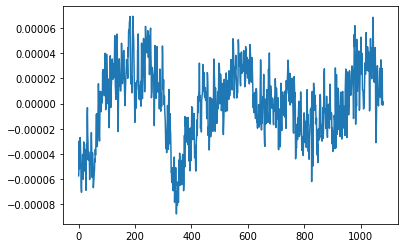

In [136]:
filename = files[7]
print(filename)


dat = sio.loadmat(filename, 
              variable_names = ['idxevent', 'fs', 'lfptrial', 'idxevent_varNames'], 
              squeeze_me = True,
              mat_dtype = True)


# extract idxevent: numpy.ndarray(shape = (ntrials, 5)), idxevent_varNames: numpy.ndarray(nshape = (5,))
idxevent, idxevent_varNames = dat['idxevent'], dat['idxevent_varNames']

# extract fs
fs = dat['fs']

# extract lfp trial: nchns * ntemporals * ntrials
lfptrial = dat['lfptrial']
dat = sio.loadmat(filename, 
              variable_names = ['idxevent', 'fs', 'lfptrial', 'idxevent_varNames'], 
              squeeze_me = True,
              mat_dtype = True)


# extract idxevent: numpy.ndarray(shape = (ntrials, 5)), idxevent_varNames: numpy.ndarray(nshape = (5,))
idxevent, idxevent_varNames = dat['idxevent'], dat['idxevent_varNames']

# extract fs
fs = dat['fs']

# extract lfp trial: nchns * ntemporals * ntrials
lfptrial = dat['lfptrial']




# column index for event return
coli_return = [i for i, s in enumerate(idxevent_varNames) if 'ReturnTimeix' in s]

# column index for event Touch
coli_mouth = [i for i, s in enumerate(idxevent_varNames) if 'MouthTimeix' in s]


# column indices of return phase 
cols_phasereturn = coli_return + coli_mouth

cols = cols_phasereturn


# minimal and maximal duration for return phase


# idxdur_min, idxdur_max
idxdur_min, idxdur_max = int(np.round(tdur_min * fs)), int(np.round(tdur_max * fs))


ntrials, _= idxevent.shape

# dictionary powers_dict for storing power of each frequency
powers_dict = dict()

### calculate the power of each frequency in freqs_all from all the trials ###
for triali in range(ntrials):

    ### data extraction part ###

    # start and end indices over time of specific phase for triali 
    idxtime_str, idxtime_end = int(idxevent[triali, cols[0]]), int(idxevent[triali, cols[1]])


    # remove trials of return phase longer than tdur_max and shorter than tdur_min
    if idxtime_end - idxtime_str < idxdur_min or idxtime_end - idxtime_str > idxdur_max:
        continue;


    # extract lfp data of chns in return phase for triali: shape = (nchns, ntemporals)
    lfp_return = lfptrial[chns, idxtime_str:idxtime_end, triali]

    # average across all the channels: shape = (ntemporals,)
    avglfp_return = np.mean(lfp_return, axis = 0)


    ### power calculation part ###

    # fft number
    nfft = len(avglfp_return)

    # Discrete Fourier Transform sample frequencies
    freqs = fftfreq(nfft, 1/fs)

    # ignore the negative frequencies
    idx_f = freqs >0
    freqs = freqs[idx_f]


    # compute the one-dimensional discrete Fourier transform
    fft_lfp = fft(avglfp_return)

    # power
    power_lfp = np.square(np.abs(fft_lfp))/nfft
    power_lfp = power_lfp[idx_f]


    ### round power to the nearest frequency in freqs_all ### 

    # index of the nearest frequency for all the frequency in freqs
    idx_round = [np.abs(freqs_all - freq).argmin() for freq in freqs if freq <= freqs_all[-1] + 0.5]

    # add power of each nearest frequency into dictionary powers_dict
    for i in idx_round:
        if i in powers_dict.keys():
            powers_dict[i] = powers_dict[i] + [power_lfp[i]]
        else:
            powers_dict[i] = [power_lfp[i]]

    ### delete temporal variables ###

    del idxtime_str, idxtime_end, lfp_return, avglfp_return
    del nfft, freqs, idx_f, fft_lfp, power_lfp
    del idx_round,i 
    
    
tdur_min, tdur_max = 0.5, 0.7

chns = chns_M1

chns = np.asarray([i for i in range(1,6)])
lfp_return = np.mean(lfptrial[chns,:, 3], axis = 0)

chni = 0
lpf_1chn = lfptrial[chni,:, 3]
plt.plot(lfp_return)
plt.show()

In [135]:
for i in range(len(files)):
    print(files[i])

/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101117_bktdt1.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_110917_bktdt2.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_112017_bktdt4.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101617_bktdt4.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_102717_bktdt3.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101217_bktdt3.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_101917_bktdt4.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs/Pinky_lfptrial_mild_102417_bktdt3.mat
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/dat